# Milestone 3: SEC Filing Sentiment Analysis

This notebook demonstrates sentiment analysis on SEC filings using FinBERT.

**Key components:**
1. EDGAR filing download and text extraction
2. FinBERT sentiment scoring
3. Time-series sentiment features
4. Regime-conditional sentiment analysis

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
plt.style.use('seaborn-v0_8-whitegrid')

print("Imports complete!")

Imports complete!


## 1. Understanding SEC Filing Structure

SEC 10-K (annual) and 10-Q (quarterly) filings contain several key sections:

| Section | Content | Sentiment Signal |
|---------|---------|------------------|
| **Item 1A: Risk Factors** | Forward-looking concerns | Negative sentiment = increased risk awareness |
| **Item 7: MD&A** | Management's view on performance | Tone reveals confidence level |
| **Item 1: Business** | Company description | Generally neutral |

We focus on **Risk Factors** and **MD&A** as they contain the most actionable sentiment signals.

In [2]:
# Demonstrate EDGAR filing download
from data.edgar_loader import EDGARLoader

# Initialize loader
edgar = EDGARLoader(email="research@example.com")

# Get recent 10-K filings for SPY's largest holding (AAPL)
print("Fetching AAPL 10-K filings...")
filings = edgar.get_filings('AAPL', filing_type='10-K', count=5)

print(f"\nFound {len(filings)} filings:")
for f in filings:
    print(f"  {f.filing_date}: {f.filing_type} - {f.company_name}")

Fetching AAPL 10-K filings...

Found 5 filings:
  2025-10-31: 10-K - Apple Inc.
  2024-11-01: 10-K - Apple Inc.
  2023-11-03: 10-K - Apple Inc.
  2022-10-28: 10-K - Apple Inc.
  2021-10-29: 10-K - Apple Inc.


In [3]:
# Extract text from the most recent filing
if filings:
    latest = filings[0]
    print(f"Extracting text from {latest.filing_date} filing...")
    
    text_sections = edgar.extract_filing_text(latest, sections=['item_1a', 'item_7'])
    
    print("\nExtracted sections:")
    for section, text in text_sections.items():
        print(f"  {section}: {len(text):,} characters")
        # Show first 500 chars
        print(f"  Preview: {text[:500]}...\n")

Extracting text from 2025-10-31 filing...

Extracted sections:
  item_1a: 109 characters
  Preview: Item 1A. Risk Factors 5 Item 1B. Unresolved Staff Comments 17 Item 1C. Cybersecurity 17 Item 2. Properties 17...

  item_7: 167 characters
  Preview: Item 7. Management’s Discussion and Analysis of Financial Condition and Results of Operations 21 Item 7A. Quantitative and Qualitative Disclosures About Market Risk 27...



## 2. FinBERT Sentiment Analysis

**Why FinBERT over generic sentiment models?**

| Model | Training Data | Financial Accuracy |
|-------|--------------|--------------------|
| VADER | Social media | ~60% on financial text |
| TextBlob | General text | ~55% on financial text |
| **FinBERT** | Financial communication | ~85% on financial text |

FinBERT understands domain-specific language:
- "Headwinds" = negative
- "Beat expectations" = positive
- "In line with guidance" = neutral

In [4]:
# Initialize FinBERT analyzer
from sentiment.finbert_analyzer import FinBERTAnalyzer

print("Initializing FinBERT analyzer...")
print("(Model will be downloaded on first use - ~400MB)")

analyzer = FinBERTAnalyzer()

# Test with sample financial sentences
test_sentences = [
    "Revenue increased 25% year over year, exceeding analyst expectations.",
    "The company faces significant headwinds from increased competition and supply chain disruptions.",
    "Total assets were $500 million as of December 31, 2023.",
    "Despite challenging market conditions, we maintained strong margins through operational efficiency.",
]

print("\nAnalyzing sample sentences:")
print("=" * 80)
for sentence in test_sentences:
    result = analyzer.analyze(sentence)
    print(f"\nText: {sentence[:70]}...")
    print(f"  Label: {result['label']}")
    print(f"  Positive: {result['positive']:.3f}")
    print(f"  Negative: {result['negative']:.3f}")
    print(f"  Neutral:  {result['neutral']:.3f}")
    print(f"  Compound: {result['compound']:.3f}")

Initializing FinBERT analyzer...
(Model will be downloaded on first use - ~400MB)

Analyzing sample sentences:
Loading FinBERT model (this may take a moment)...


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

FinBERT loaded on GPU

Text: Revenue increased 25% year over year, exceeding analyst expectations....
  Label: positive
  Positive: 0.957
  Negative: 0.019
  Neutral:  0.024
  Compound: 0.938

Text: The company faces significant headwinds from increased competition and...
  Label: negative
  Positive: 0.011
  Negative: 0.969
  Neutral:  0.020
  Compound: -0.959

Text: Total assets were $500 million as of December 31, 2023....
  Label: neutral
  Positive: 0.023
  Negative: 0.032
  Neutral:  0.945
  Compound: -0.009

Text: Despite challenging market conditions, we maintained strong margins th...
  Label: positive
  Positive: 0.955
  Negative: 0.014
  Neutral:  0.032
  Compound: 0.941


## 3. Analyze Full Filing Sections

Now let's analyze the Risk Factors and MD&A sections from actual filings.

In [5]:
# Analyze extracted sections
if 'text_sections' in dir() and text_sections:
    print("Analyzing filing sections (this may take a minute)...")
    
    section_results = {}
    for section, text in text_sections.items():
        if text and len(text) > 100:
            result = analyzer.analyze(text)
            section_results[section] = result
            print(f"\n{section.upper()}:")
            print(f"  Text length: {len(text):,} chars")
            print(f"  Sentiment: {result['label']}")
            print(f"  Compound score: {result['compound']:.3f}")
else:
    print("No filing text available. Run the EDGAR extraction cell first.")

Analyzing filing sections (this may take a minute)...

ITEM_1A:
  Text length: 109 chars
  Sentiment: neutral
  Compound score: -0.139

ITEM_7:
  Text length: 167 chars
  Sentiment: neutral
  Compound score: 0.009


## 4. Filing Sentiment Pipeline

The `FilingSentimentPipeline` automates the full workflow:
1. Download filings from EDGAR
2. Extract relevant sections
3. Analyze sentiment
4. Create time-series features

In [6]:
from sentiment.filing_sentiment import FilingSentimentPipeline

# Initialize pipeline
pipeline = FilingSentimentPipeline()

# Get filing-level sentiment for AAPL
print("Fetching and analyzing AAPL filings...")
print("(This fetches 10-K and 10-Q filings and analyzes each one)")

filing_df = pipeline.get_filing_sentiment(
    ticker='AAPL',
    filing_types=['10-K', '10-Q'],
    start_date='2021-01-01',
    end_date='2024-01-01'
)

if not filing_df.empty:
    print(f"\nAnalyzed {len(filing_df)} filings:")
    display_cols = ['filing_date', 'filing_type', 'overall_compound', 'overall_label']
    available_cols = [c for c in display_cols if c in filing_df.columns]
    print(filing_df[available_cols].to_string())
else:
    print("No filings processed. Check for errors above.")

Fetching and analyzing AAPL filings...
(This fetches 10-K and 10-Q filings and analyzes each one)

Analyzed 12 filings:
   filing_date filing_type  overall_compound overall_label
11  2021-01-28        10-Q         -0.090737       neutral
10  2021-04-29        10-Q         -0.126477       neutral
9   2021-07-28        10-Q         -0.126477       neutral
2   2021-10-29        10-K         -0.198689       neutral
8   2022-01-28        10-Q         -0.085111       neutral
7   2022-04-29        10-Q         -0.085111       neutral
6   2022-07-29        10-Q         -0.086649       neutral
1   2022-10-28        10-K         -0.199455       neutral
5   2023-02-03        10-Q         -0.089616       neutral
4   2023-05-05        10-Q         -0.086649       neutral
3   2023-08-04        10-Q         -0.003909       neutral
0   2023-11-03        10-K         -0.085856       neutral


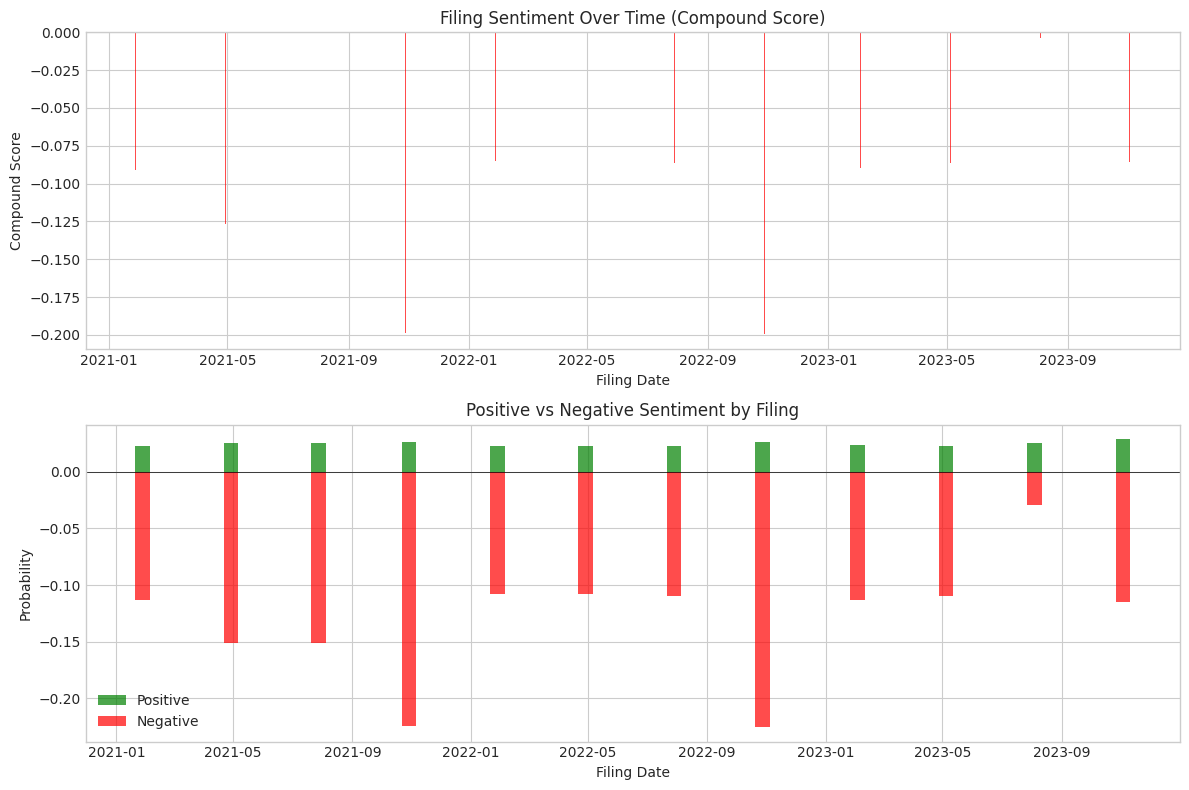

In [7]:
# Visualize sentiment over time
if not filing_df.empty and 'overall_compound' in filing_df.columns:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Compound score over time
    ax = axes[0]
    colors = ['green' if c > 0 else 'red' for c in filing_df['overall_compound']]
    ax.bar(filing_df['filing_date'], filing_df['overall_compound'], color=colors, alpha=0.7)
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax.set_title('Filing Sentiment Over Time (Compound Score)')
    ax.set_ylabel('Compound Score')
    ax.set_xlabel('Filing Date')
    
    # Sentiment breakdown
    ax = axes[1]
    if 'overall_positive' in filing_df.columns:
        width = 15  # days
        dates = filing_df['filing_date']
        ax.bar(dates, filing_df['overall_positive'], width=width, label='Positive', color='green', alpha=0.7)
        ax.bar(dates, -filing_df['overall_negative'], width=width, label='Negative', color='red', alpha=0.7)
        ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
        ax.set_title('Positive vs Negative Sentiment by Filing')
        ax.set_ylabel('Probability')
        ax.set_xlabel('Filing Date')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No sentiment data to visualize.")

## 5. Creating Daily Sentiment Features

For modeling, we need daily features. The pipeline:
1. Forward-fills sentiment from filing date until next filing
2. Adds change features (vs previous filing)
3. Adds days-since-filing as a feature

In [8]:
# Get daily sentiment features
print("Creating daily sentiment features...")

daily_sentiment = pipeline.get_sentiment_features(
    ticker='AAPL',
    start_date='2022-01-01',
    end_date='2024-01-01'
)

if not daily_sentiment.empty:
    print(f"\nDaily features shape: {daily_sentiment.shape}")
    print(f"Date range: {daily_sentiment.index.min()} to {daily_sentiment.index.max()}")
    print(f"\nFeatures created:")
    for col in daily_sentiment.columns:
        print(f"  - {col}")
    
    print("\nSample data (around filing dates):")
    filing_days = daily_sentiment[daily_sentiment['is_filing_day'] == 1].head(5)
    print(filing_days[['overall_compound', 'days_since_filing', 'is_filing_day']].to_string())
else:
    print("No daily features created.")

Creating daily sentiment features...

Daily features shape: (731, 16)
Date range: 2022-01-01 00:00:00 to 2024-01-01 00:00:00

Features created:
  - overall_positive
  - overall_negative
  - overall_neutral
  - overall_compound
  - item_1a_positive
  - item_1a_negative
  - item_1a_compound
  - item_7_positive
  - item_7_negative
  - item_7_compound
  - overall_compound_change
  - overall_positive_change
  - overall_negative_change
  - sentiment_surprise
  - days_since_filing
  - is_filing_day

Sample data (around filing dates):
            overall_compound  days_since_filing  is_filing_day
2022-01-28         -0.085111                0.0              1
2022-04-29         -0.085111                0.0              1
2022-07-29         -0.086649                0.0              1
2022-10-28         -0.199455                0.0              1
2023-02-03         -0.089616                0.0              1


## 6. Sentiment by Filing Type

Do 10-K (annual) filings have different sentiment than 10-Q (quarterly)?

Sentiment by Filing Type:
              mean    std  count
filing_type                     
10-K        -0.161  0.065      3
10-Q        -0.087  0.035      9


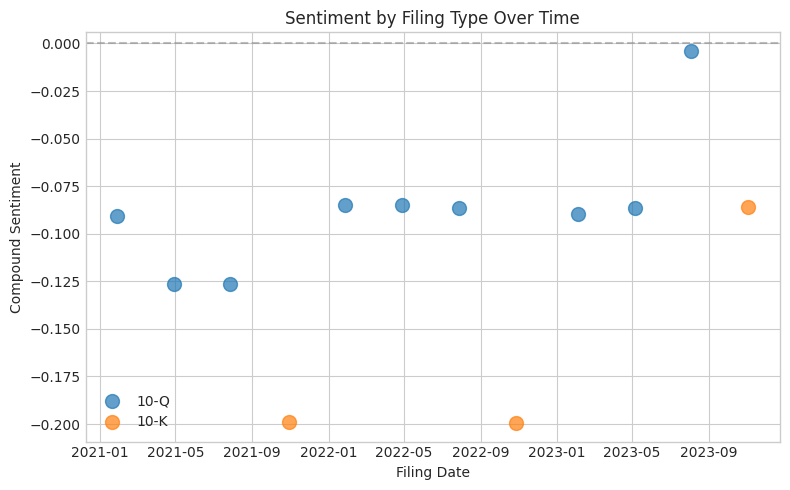

In [9]:
if not filing_df.empty and 'overall_compound' in filing_df.columns:
    # Compare by filing type
    sentiment_by_type = filing_df.groupby('filing_type')['overall_compound'].agg(['mean', 'std', 'count'])
    print("Sentiment by Filing Type:")
    print(sentiment_by_type.round(3))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(8, 5))
    
    for ftype in filing_df['filing_type'].unique():
        mask = filing_df['filing_type'] == ftype
        ax.scatter(
            filing_df.loc[mask, 'filing_date'],
            filing_df.loc[mask, 'overall_compound'],
            label=ftype,
            s=100,
            alpha=0.7
        )
    
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_title('Sentiment by Filing Type Over Time')
    ax.set_xlabel('Filing Date')
    ax.set_ylabel('Compound Sentiment')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No filing data available.")

## 7. Section-Level Analysis

Risk Factors vs MD&A sentiment can diverge - companies may acknowledge risks while remaining optimistic in MD&A.

Average divergence (MD&A - Risk): 0.347
MD&A is typically more optimistic than Risk Factors


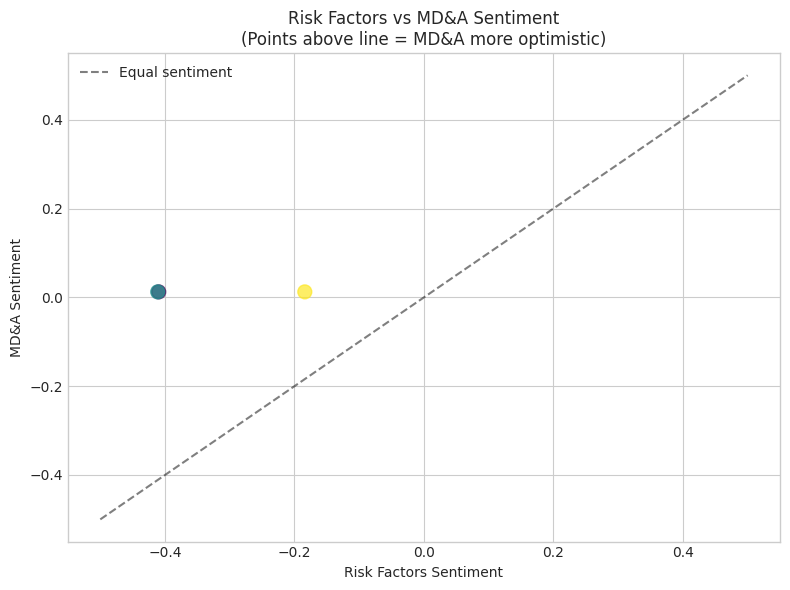

In [10]:
if not filing_df.empty:
    # Check if section-level scores exist
    risk_col = 'item_1a_compound' if 'item_1a_compound' in filing_df.columns else None
    mda_col = 'item_7_compound' if 'item_7_compound' in filing_df.columns else None
    
    if risk_col and mda_col:
        fig, ax = plt.subplots(figsize=(8, 6))
        
        ax.scatter(
            filing_df[risk_col],
            filing_df[mda_col],
            c=filing_df['filing_date'].astype(int),
            cmap='viridis',
            s=100,
            alpha=0.7
        )
        
        # Add diagonal line (equal sentiment)
        lims = [-0.5, 0.5]
        ax.plot(lims, lims, 'k--', alpha=0.5, label='Equal sentiment')
        
        ax.set_xlabel('Risk Factors Sentiment')
        ax.set_ylabel('MD&A Sentiment')
        ax.set_title('Risk Factors vs MD&A Sentiment\n(Points above line = MD&A more optimistic)')
        ax.legend()
        
        # Calculate divergence
        divergence = filing_df[mda_col] - filing_df[risk_col]
        print(f"Average divergence (MD&A - Risk): {divergence.mean():.3f}")
        print(f"MD&A is typically {'more' if divergence.mean() > 0 else 'less'} optimistic than Risk Factors")
        
        plt.tight_layout()
        plt.show()
    else:
        print("Section-level sentiment not available.")
        print(f"Available columns: {filing_df.columns.tolist()}")

## 8. Key Findings Summary

In [11]:
print("=" * 70)
print("MILESTONE 3: SEC FILING SENTIMENT - KEY FINDINGS")
print("=" * 70)

if not filing_df.empty and 'overall_compound' in filing_df.columns:
    print(f"\n1. FILINGS ANALYZED: {len(filing_df)}")
    print(f"   Date range: {filing_df['filing_date'].min()} to {filing_df['filing_date'].max()}")
    
    print(f"\n2. OVERALL SENTIMENT:")
    print(f"   Mean compound score: {filing_df['overall_compound'].mean():.3f}")
    print(f"   Std deviation: {filing_df['overall_compound'].std():.3f}")
    
    # Count by label
    if 'overall_label' in filing_df.columns:
        label_counts = filing_df['overall_label'].value_counts()
        print(f"\n3. SENTIMENT DISTRIBUTION:")
        for label, count in label_counts.items():
            pct = count / len(filing_df) * 100
            print(f"   {label}: {count} ({pct:.1f}%)")
    
    if not daily_sentiment.empty:
        print(f"\n4. DAILY FEATURES CREATED: {len(daily_sentiment.columns)} features")
        print(f"   Days covered: {len(daily_sentiment)}")
else:
    print("\nNo filing sentiment data available.")
    print("This may be due to:")
    print("  - Network issues fetching from EDGAR")
    print("  - Model download not completed")
    print("  - Processing errors")

print("\n" + "=" * 70)

MILESTONE 3: SEC FILING SENTIMENT - KEY FINDINGS

1. FILINGS ANALYZED: 12
   Date range: 2021-01-28 00:00:00 to 2023-11-03 00:00:00

2. OVERALL SENTIMENT:
   Mean compound score: -0.105
   Std deviation: 0.053

3. SENTIMENT DISTRIBUTION:
   neutral: 12 (100.0%)

4. DAILY FEATURES CREATED: 16 features
   Days covered: 731



In [12]:
print("\nNotebook complete!")
print("\nNext steps:")
print("  - Combine sentiment features with price and macro data")
print("  - Analyze regime-conditional sentiment effects")
print("  - Test if sentiment improves prediction within regimes")


Notebook complete!

Next steps:
  - Combine sentiment features with price and macro data
  - Analyze regime-conditional sentiment effects
  - Test if sentiment improves prediction within regimes
